In [1]:
from bs4 import BeautifulSoup
from pprint import pprint
from urllib import request
import nltk
import json
import time


class WowClassesResources:

    def __init__(self):
        None

    WOW_FORUM_ROOT_URL_EU = 'http://eu.battle.net'
    WOW_FORUM_ROOT_URL_US = 'http://us.battle.net'
    WOW_FORUM_MID_URL = '/forums/en/wow/'
    URL_PAGE_ATTRIBUTE = "?page="

    WOW_CLASS_LIST_EU = [('Death Knight', "874789/"),
                      ('Demon Hunter', "19369494/"),
                      ('Druid', "874790/"),
                      ('Hunter', "874791/"),
                      ('Mage', "874792/"),
                      ('Monk', "6038099/"),
                      ('Paladin', "874793/"),
                      ('Priest', "874794/"),
                      ('Rogue', "874795/"),
                      ('Shaman', "874796/"),
                      ('Warlock', "874929/"),
                      ('Warrior', "874930/")]
    WOW_CLASS_LIST_US = [('Death Knight', "1012662/"),
                      ('Demon Hunter', "22813967/"),
                      ('Druid', "1012663/"),
                      ('Hunter', "1012664/"),
                      ('Mage', "1012760/"),
                      ('Monk', "7379141/"),
                      ('Paladin', "1012668/"),
                      ('Priest', "1012666/"),
                      ('Rogue', "1012667/"),
                      ('Shaman', "1012669/"),
                      ('Warlock', "1012670/"),
                      ('Warrior', "1012759/")]

    class GameType:
        # PVP: 2v2 3v3 5v5
        PVP = 'pvp'
        PVE = 'pve'
        OTHER = 'other'

WOW_TOPIC_URLS_EU = \
    [(c, WowClassesResources.WOW_FORUM_ROOT_URL_EU + WowClassesResources.WOW_FORUM_MID_URL + u)
     for (c, u) in WowClassesResources.WOW_CLASS_LIST_EU]

In [2]:
print(WOW_TOPIC_URLS_EU[0])
url = WOW_TOPIC_URLS_EU[0][1]
# req = request.Request(url)
response = request.urlopen(url)
html = response.read().decode('utf8')
print(html[:100])

('Death Knight', 'http://eu.battle.net/forums/en/wow/874789/')





<html xmlns="http://www.w3.org/1999/xhtml">

<head>
	<meta http-equiv="X-UA-Compatible" content="


In [3]:
def get_page_content(url):
    attempt_number = 0
    while True:
        attempt_number += 1
        if attempt_number > 5:
            return None
        try:
            response = request.urlopen(url)
        except request.HTTPError as e:
            print('HTTPError = ' + str(e.code))
            continue
        except Exception as e:
            print(e)
            continue
        except e:
            print(e)
            continue
        html = response.read().decode('utf8')
        break
    return html


def topic_scrape(forum_url):
    all_links = []
    i = 1
    while True:
        html = get_page_content(forum_url + WowClassesResources.URL_PAGE_ATTRIBUTE + str(i))
        if html is None:
            return []
        bs_html = BeautifulSoup(html, "html.parser")

        all_link_elements = bs_html.find_all("a", class_="ForumTopic")
        # pprint(all_link_elements)
        link_count = len(all_link_elements)
        print(str(i) + ' ' + str(link_count))

        if link_count == 0:
            print('Exiting')
            break
        for a in all_link_elements:
            # print a
            title = a.find(class_='ForumTopic-title').get_text().strip()
            # print title
            all_links.append((a['href'], title))
        i += 1
        time.sleep(10)
    return all_links


def extract_topic(topic_title_url_tuple):
    topic_url_ending = topic_title_url_tuple[0]
    topic_title = topic_title_url_tuple[1]
    pprint('[' + topic_title + '] (' + topic_url_ending + ')')
    all_posts = []
    i = 1
    while True:
        html = get_page_content(
            WowClassesResources.WOW_FORUM_ROOT_URL_EU + topic_url_ending + WowClassesResources.URL_PAGE_ATTRIBUTE + str(
                i))
        if html is None:
            return []
        bs_html = BeautifulSoup(html, "html.parser")

        all_topic_post_elements = bs_html.find_all("div", class_="TopicPost-content")
        # pprint(all_topic_post_elements)
        link_count = len(all_topic_post_elements)
        # print str(i) + ' ' + str(link_count)

        if link_count == 0:
            print('Exiting')
            break
        for element in all_topic_post_elements:
            # print a
            post_body = element.find(class_='TopicPost-bodyContent').get_text().strip()
            post_date = element.find("a", class_='TopicPost-timestamp')['data-tooltip-content']
            author_element = element.find("span", class_='Author-name')
            if author_element is not None:
                # post_author = '<UNKNOWN>'
                if author_element.a is not None:
                    post_author = author_element.a.get_text().strip()
                else:
                    post_author = author_element.get_text().strip()
                all_posts.append((topic_title, post_date, post_author, post_body))
        i += 1
        time.sleep(3)
    pprint('posts: ' + str(len(all_posts)))
    return all_posts


def save_to_json_file(path, file_name, topic_content_tuple_list, mode):
    with open(path + file_name + '.json', mode) as out_file:
        json.dump(topic_content_tuple_list, out_file)


def read_from_json_file(path, file_name):
    with open(path + file_name + '.json', 'r') as in_file:
        return json.load(in_file)

In [4]:
# READ CURRENT CLASS TO WORK WITH
currentClass = WOW_TOPIC_URLS_EU[0]
print('Current Class: ' + currentClass[0] + ', URL: ' + currentClass[1])
# READ DICTIONARY OF POSTS
posts_by_class = read_from_json_file('Resources/Corpora/EU/Posts/', 'corpora_posts_' + currentClass[0])
print('Number of posts: ' + str(len(posts_by_class[currentClass[0]])))
# print('First post:\n' + posts_by_class[currentClass[0]][0][3])

Current Class: Death Knight, URL: http://eu.battle.net/forums/en/wow/874789/


Number of posts: 34186


In [6]:
# READ ONTOLOGY
from owlready import *
onto_path.clear()
#onto_path.append("./Resources/")
wowOnto = get_ontology('file://Resources/Ontology/OWLXML.owl').load(True)

print(wowOnto.classes)
print(to_owl(wowOnto))

[OWLXML.Destruction, OWLXML.Mage, OWLXML.Shaman, OWLXML.Rogue, OWLXML.Beast_Mastery, OWLXML.Elemental, OWLXML.Druid, OWLXML.H, OWLXML.Arcane, OWLXML.Prot, OWLXML.Demon_Hunter, OWLXML.Fire, OWLXML.Arms, OWLXML.Priest, OWLXML.Mistweaver, OWLXML.Affliction, OWLXML.Balance, OWLXML.Survival, OWLXML.Holy, OWLXML.Demonology, OWLXML.Shadow, OWLXML.Warrior]
<?xml version="1.0"?>
<!DOCTYPE Ontology [
    <!ENTITY xsd "http://www.w3.org/2001/XMLSchema#" >
    <!ENTITY rdf "http://www.w3.org/1999/02/22-rdf-syntax-ns#" >
    <!ENTITY rdfs "http://www.w3.org/2000/01/rdf-schema#" >
    <!ENTITY owl "http://www.w3.org/2002/07/owl#" >
]>
<Ontology xmlns="http://www.w3.org/2002/07/owl#" xml:base="file://Resources/Ontology/OWLXML.owl" ontologyIRI="file://Resources/Ontology/OWLXML.owl"
     xmlns:rdfs="http://www.w3.org/2000/01/rdf-schema#"
     xmlns:xsd="http://www.w3.org/2001/XMLSchema#"
     xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#"
     xmlns:xml="http://www.w3.org/XML/1998/namespace"
>

In [6]:
posts_with_game_type = {}

posts_with_game_type[currentClass[0]] = []
for post in posts_by_class[currentClass[0]]:
    # print(post[2] + '\t' + post[0]
    #       + '-\t\tpvp:\t' + str(post[3].lower().find(WowClassesResources.GameType.PVP))
    #       + '\t\tpve:\t' + str(post[3].lower().find(WowClassesResources.GameType.PVE)))
    updatedPost = post
    updatedPost.append(WowClassesResources.GameType.OTHER)
    pvpIndex = post[3].lower().find(WowClassesResources.GameType.PVP)
    pveIndex = post[3].lower().find(WowClassesResources.GameType.PVE)
    if pvpIndex == -1 and pveIndex == -1:
        updatedPost[4] = WowClassesResources.GameType.OTHER
    elif pvpIndex != -1 and pveIndex == -1:
        updatedPost[4] = WowClassesResources.GameType.PVP
    elif pvpIndex == -1 and pveIndex != -1:
        updatedPost[4] = WowClassesResources.GameType.PVE
    elif pvpIndex <= pveIndex:
        updatedPost[4] = WowClassesResources.GameType.PVP
    else:
        updatedPost[4] = WowClassesResources.GameType.PVE
    posts_with_game_type[currentClass[0]].append(updatedPost)

# pprint(posts_with_game_type[currentClass[0]][:10])
pprint(posts_by_class[currentClass[0]][:10])

[['[Guide]Death Knight 101 (Updated for 7.03)',
  '22/05/2014 11:27',
  'Hakuteiken',
  'This if for all the really new Death Knights; my guide on the class '
  "overall. In this guide I'll be covering our resource system, what abilities "
  "you have, how they work and what they do. I'll also throw in some "
  'suggestions on gameplay that should make things somewhat easier for '
  "you.It's worth nothing that Death Knights, at lower levels, are "
  'ridiculously powerful which is a state of affairs I found to be really dull '
  "when leveling my latest Death Knight; it's not much fun when you're "
  'immortal and killing things with 2-3 attacks, but anyway, here goes.First '
  "thing's first; Resources-We have two different resources; Runes and Runic "
  'Power.We have a total of 6 runes which can be used for any attack that '
  'costs Runes; Obliterate, Howling Blast, Festering Strike, Marrowrend '
  'etc.-Runic Power is generated from used runes and the amount of runic power '
  'g

other   pvp   pve 
30021  3064  1101 
None


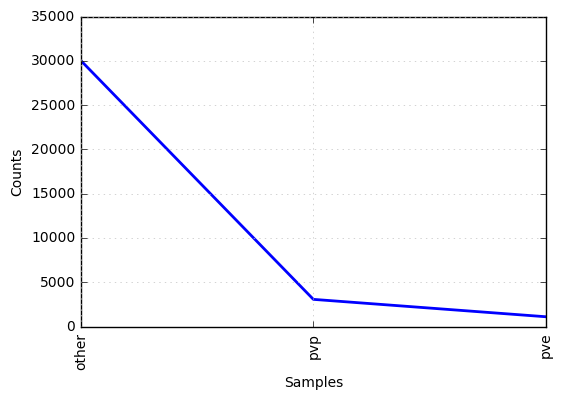

None


In [7]:
# plot histogram of findings
import matplotlib.pyplot as plt
import numpy
post_game_type_distribution = [post[4] for post in posts_with_game_type[currentClass[0]]]

fdistGameType = nltk.FreqDist(post_game_type_distribution)
pprint(fdistGameType.tabulate())
pprint(fdistGameType.plot())